# Bangkok :  the district of food
## Introduction
Bangkok is one of the most exciting cities in the world especially if you are a food lover. Bangkok is very famous on food. People always have a hard time when they have to determine what to eat.

In this project, we will provide a dining and restaurant guide for people who plans to travel to Bangkok or even the local people by recommending the top 10 type of restaurant in each district. In addition, this project may useful for a stakeholder who wants to open a restaurant in Bangkok.

## Data Sets and APIs

2. Foursquare API  
This project would use Four-square API as its data gathering source to obtained the venue and restaurant information. Foursquare is a location-based online social network, and Foursquare Places API offers real-time access to its global database for developers to explore the attributes of commercial venues. https://developer.foursquare.com/docs/places-api/


### Bangkok District location data
We will use the table provide in [https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok](https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok) by scraping the website with package Beautiful soup

In [40]:
import pandas as pd
import numpy as np
import requests 
from bs4 import BeautifulSoup 

req = requests.get("https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok") 
soup = BeautifulSoup(req.content,'lxml') 
table = soup.find_all('table')[0]  
bkk = pd.read_html(str(table)) 

bkk =pd.DataFrame(bkk[0])
print("We found ",bkk.shape[0]," row and ",bkk.shape[1]," columns of district. The following table show the first 10 rows")
bkk.head(10)

We found  50  row and  8  columns of district. The following table show the first 10 rows


,District(Khet),MapNr,Post-code,Thai,Popu-lation,No. ofSubdis-trictsKhwaeng,Latitude,Longitude
0,Bang Bon,50,10150,บางบอน,105161,4,13.659200,100.399100
1,Bang Kapi,6,10240,บางกะปิ,148465,2,13.765833,100.647778
2,Bang Khae,40,10160,บางแค,191781,4,13.696111,100.409444
3,Bang Khen,5,10220,บางเขน,189539,2,13.873889,100.596389
4,Bang Kho Laem,31,10120,บางคอแหลม,94956,3,13.693333,100.502500
5,Bang Khun Thian,21,10150,บางขุนเทียน,165491,2,13.660833,100.435833
6,Bang Na,47,10260,บางนา,95912,2,13.680081,100.591800
7,Bang Phlat,25,10700,บางพลัด,99273,4,13.793889,100.505000
8,Bang Rak,4,10500,บางรัก,45875,5,13.730833,100.524167
9,Bang Sue,29,10800,บางซื่อ,132234,2,13.809722,100.537222


In [41]:
bkk = bkk.drop(['MapNr','Post-code','Thai'],1)
bkk.rename(index=str, columns={"District(Khet)":"District","Popu-lation":"Population","No. ofSubdis-trictsKhwaeng":"num_subdistrict"},inplace=True)

In [42]:
bkk.head()

,District,Population,num_subdistrict,Latitude,Longitude
0,Bang Bon,105161,4,13.659200,100.399100
1,Bang Kapi,148465,2,13.765833,100.647778
2,Bang Khae,191781,4,13.696111,100.409444
3,Bang Khen,189539,2,13.873889,100.596389
4,Bang Kho Laem,94956,3,13.693333,100.502500


In [43]:
bkk.dtypes

District            object
Population           int64
num_subdistrict      int64
Latitude           float64
Longitude          float64
dtype: object

In [4]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

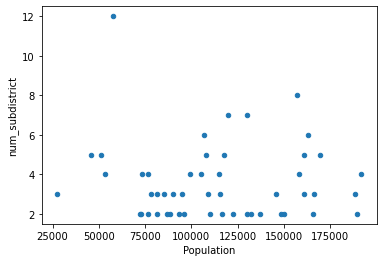

In [8]:
#scatter plot of population and no. of subdistrict
bkk.plot(kind="scatter",y="num_subdistrict",x="Population")
plt.show()

In [9]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

# create map of Bangkok using latitude and longitude values 13.736717, 100.523186
# for the purpose of visualize, we manually adjust the center of the map

map_bkk = folium.Map(location=[13.76, 100.6], zoom_start=11)

# add markers to map
for lat, lng, district in zip(bkk['Latitude'], bkk['Longitude'], bkk['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_bkk)  
    
map_bkk

## Foursquare

In [10]:
#Foursquare credential and versions

#Hide credential detail
CLIENT_ID = '0XP33P2YTO5FSJN4F4XUXVIXREEZTAVU1GLDYHV5UXB5NYEA' # your Foursquare ID
CLIENT_SECRET = 'DNBVVHTS1O0QWGURKQH4BCLNLHG02D0DQH0EGM0KS5QC1JLO' # your Foursquare Secret
VERSION = '20210117' # Foursquare API version

In [11]:
#Get the top 100 venues nearby each district within a radius of 2000 meters.
#We use categoryId = 4d4b7105d754a06374d81259 which is food (https://developer.foursquare.com/docs/build-with-foursquare/categories/)
radius = 2000
LIMIT = 100

venues = []

for lat, long, district in zip(bkk['Latitude'], bkk['Longitude'], bkk['District']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7105d754a06374d81259".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            district, 
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [12]:
# convert the venues list into a DataFrame
venues_df = pd.DataFrame(venues)

# name the column
venues_df.columns = ['District', 'DistrictLatitude', 'DistrictLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(4118, 7)


,District,DistrictLatitude,DistrictLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Bang Bon,13.6592,100.3991,ขาหมูบางหว้า,13.657136,100.395230,Thai Restaurant
1,Bang Bon,13.6592,100.3991,เจ๊ไน้ ก๋วยเตี๋ยวเป็ดตุ๋น,13.654137,100.405323,Noodle House
2,Bang Bon,13.6592,100.3991,KFC,13.670449,100.405502,Fast Food Restaurant
3,Bang Bon,13.6592,100.3991,Burger King (เบอร์เกอร์คิง),13.670830,100.405089,Fast Food Restaurant
4,Bang Bon,13.6592,100.3991,หมูสะเต๊ะแม่กำไร,13.653672,100.391620,Satay Restaurant


In [13]:
venues_df.groupby(["District"]).count()

,DistrictLatitude,DistrictLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
District,,,,,,
Bang Bon,61,61,61,61,61,61
Bang Kapi,100,100,100,100,100,100
Bang Khae,66,66,66,66,66,66
Bang Khen,71,71,71,71,71,71
Bang Kho Laem,100,100,100,100,100,100
Bang Khun Thian,82,82,82,82,82,82
Bang Na,71,71,71,71,71,71
Bang Phlat,100,100,100,100,100,100
Bang Rak,100,100,100,100,100,100


In [14]:
#Content analysis: how many unique categories can found in the list of venues?
print('There are {} unique categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 82 unique categories.


In [15]:
venue_unique_count = venues_df['VenueCategory'].value_counts().to_frame(name='Count')
venue_unique_count.head(20)

,Count
Noodle House,677
Thai Restaurant,597
Café,329
Asian Restaurant,226
Japanese Restaurant,202
Som Tum Restaurant,170
Chinese Restaurant,158
Restaurant,143
Fast Food Restaurant,134
Seafood Restaurant,131


## Analyze Neighborhood

In [16]:
# one hot encoding
bkk_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add District column back to dataframe
bkk_onehot['District'] = venues_df['District'] 

# move District column to the first column
fixed_columns = list(bkk_onehot.columns[-1:]) + list(bkk_onehot.columns[:-1])
bkk_onehot = bkk_onehot[fixed_columns]

print(bkk_onehot.shape)
bkk_onehot.head()

(4118, 83)


,District,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bistro,Breakfast Spot,Buffet,Burger Joint,...,Takoyaki Place,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Yoshoku Restaurant
0,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bang Bon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
#Group the rows by Neighborhood, then compute mean occurrence by category
bkk_grouped = bkk_onehot.groupby(["District"]).mean().reset_index()

print(bkk_grouped.shape)
bkk_grouped

(50, 83)


,District,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bistro,Breakfast Spot,Buffet,Burger Joint,...,Takoyaki Place,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Yoshoku Restaurant
0,Bang Bon,0.000000,0.098361,0.000000,0.000000,0.000000,0.016393,0.000000,0.016393,0.000000,...,0.00,0.00,0.180328,0.00,0.00,0.000000,0.016393,0.000000,0.000000,0.00
1,Bang Kapi,0.000000,0.020000,0.000000,0.040000,0.020000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.120000,0.00,0.00,0.000000,0.000000,0.010000,0.010000,0.00
2,Bang Khae,0.000000,0.045455,0.000000,0.045455,0.060606,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.075758,0.00,0.00,0.015152,0.000000,0.000000,0.000000,0.00
3,Bang Khen,0.000000,0.084507,0.000000,0.014085,0.028169,0.000000,0.000000,0.000000,0.014085,...,0.00,0.00,0.098592,0.00,0.00,0.000000,0.000000,0.042254,0.000000,0.00
4,Bang Kho Laem,0.000000,0.060000,0.000000,0.040000,0.000000,0.020000,0.030000,0.010000,0.000000,...,0.00,0.00,0.180000,0.00,0.00,0.000000,0.010000,0.010000,0.000000,0.00
5,Bang Khun Thian,0.000000,0.024390,0.000000,0.012195,0.036585,0.000000,0.000000,0.012195,0.000000,...,0.00,0.00,0.121951,0.00,0.00,0.000000,0.012195,0.036585,0.000000,0.00
6,Bang Na,0.014085,0.056338,0.014085,0.000000,0.028169,0.014085,0.000000,0.000000,0.000000,...,0.00,0.00,0.169014,0.00,0.00,0.000000,0.000000,0.000000,0.014085,0.00
7,Bang Phlat,0.000000,0.060000,0.000000,0.030000,0.060000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.240000,0.00,0.00,0.000000,0.000000,0.030000,0.000000,0.00
8,Bang Rak,0.000000,0.020000,0.000000,0.030000,0.010000,0.010000,0.020000,0.000000,0.010000,...,0.00,0.00,0.130000,0.00,0.01,0.000000,0.020000,0.000000,0.000000,0.00
9,Bang Sue,0.000000,0.020000,0.000000,0.050000,0.000000,0.000000,0.010000,0.000000,0.000000,...,0.00,0.00,0.250000,0.00,0.00,0.000000,0.020000,0.000000,0.000000,0.00


# Top 10 venue of each neighborhood

In [18]:
#Now create a dataframe that displays the top 10 venues by PostalCode.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['District']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = bkk_grouped['District']

for ind in np.arange(bkk_grouped.shape[0]):
    row_categories = bkk_grouped.iloc[ind, :].iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    district_venues_sorted.iloc[ind, 1:] = row_categories_sorted.index.values[0:num_top_venues]

# district_venues_sorted.sort_values(freqColumns, inplace=True)
print(district_venues_sorted.shape)
district_venues_sorted

(50, 11)


,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,Thai Restaurant,Noodle House,Asian Restaurant,Café,Chinese Restaurant,Som Tum Restaurant,Fast Food Restaurant,Food Truck,Food,Food Court
1,Bang Kapi,Noodle House,Thai Restaurant,Som Tum Restaurant,Japanese Restaurant,Fast Food Restaurant,Steakhouse,Shabu-Shabu Restaurant,BBQ Joint,Hotpot Restaurant,Chinese Restaurant
2,Bang Khae,Japanese Restaurant,Fast Food Restaurant,Hotpot Restaurant,Thai Restaurant,Seafood Restaurant,Bakery,Steakhouse,Noodle House,Café,Som Tum Restaurant
3,Bang Khen,Noodle House,Thai Restaurant,Asian Restaurant,Fast Food Restaurant,Som Tum Restaurant,Hotpot Restaurant,Café,Steakhouse,Vietnamese Restaurant,Bakery
4,Bang Kho Laem,Thai Restaurant,Noodle House,Hotpot Restaurant,Chinese Restaurant,Asian Restaurant,Seafood Restaurant,Japanese Restaurant,BBQ Joint,Restaurant,Breakfast Spot
5,Bang Khun Thian,Thai Restaurant,Noodle House,Hotpot Restaurant,Japanese Restaurant,Steakhouse,Pizza Place,Fast Food Restaurant,Café,Soup Place,Seafood Restaurant
6,Bang Na,Noodle House,Thai Restaurant,Café,Fast Food Restaurant,Som Tum Restaurant,Asian Restaurant,Food Court,Restaurant,Food Truck,Seafood Restaurant
7,Bang Phlat,Thai Restaurant,Noodle House,Café,Asian Restaurant,Bakery,Fast Food Restaurant,Vietnamese Restaurant,BBQ Joint,Som Tum Restaurant,Japanese Restaurant
8,Bang Rak,Noodle House,Thai Restaurant,Café,Seafood Restaurant,Chinese Restaurant,French Restaurant,Japanese Restaurant,Italian Restaurant,Restaurant,BBQ Joint
9,Bang Sue,Thai Restaurant,Noodle House,Som Tum Restaurant,Café,Fast Food Restaurant,BBQ Joint,Hotpot Restaurant,Steakhouse,Seafood Restaurant,Chinese Restaurant


## Clustering using K-Means clustering

In [21]:
#import k-means
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

bkk_grouped_clustering = bkk_grouped.drop(["District"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bkk_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 1, 1, 2, 2, 1, 4, 0, 4, 0])

In [22]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
bkk_merged = bkk.copy()

# add clustering labels
bkk_merged["Cluster Labels"] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bkk_merged = bkk_merged.join(district_venues_sorted.set_index("District"), on="District")

print(bkk_merged.shape)
bkk_merged.head()

(50, 16)


,District,Population,num_subdistrict,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,105161,4,13.659200,100.399100,3,Thai Restaurant,Noodle House,Asian Restaurant,Café,Chinese Restaurant,Som Tum Restaurant,Fast Food Restaurant,Food Truck,Food,Food Court
1,Bang Kapi,148465,2,13.765833,100.647778,1,Noodle House,Thai Restaurant,Som Tum Restaurant,Japanese Restaurant,Fast Food Restaurant,Steakhouse,Shabu-Shabu Restaurant,BBQ Joint,Hotpot Restaurant,Chinese Restaurant
2,Bang Khae,191781,4,13.696111,100.409444,1,Japanese Restaurant,Fast Food Restaurant,Hotpot Restaurant,Thai Restaurant,Seafood Restaurant,Bakery,Steakhouse,Noodle House,Café,Som Tum Restaurant
3,Bang Khen,189539,2,13.873889,100.596389,2,Noodle House,Thai Restaurant,Asian Restaurant,Fast Food Restaurant,Som Tum Restaurant,Hotpot Restaurant,Café,Steakhouse,Vietnamese Restaurant,Bakery
4,Bang Kho Laem,94956,3,13.693333,100.502500,2,Thai Restaurant,Noodle House,Hotpot Restaurant,Chinese Restaurant,Asian Restaurant,Seafood Restaurant,Japanese Restaurant,BBQ Joint,Restaurant,Breakfast Spot


In [23]:
#Elbow criterion method
# Import key libraries
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt

In [26]:
# create map
map_clusters = folium.Map(location=[13.76, 100.6], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, district, cluster in zip(bkk_merged['Latitude'], bkk_merged['Longitude'], bkk_merged['District'], bkk_merged['Cluster Labels']):
    label = folium.Popup('{} : Cluster {}'.format(district, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [45]:
bkk_merged[bkk_merged['Cluster Labels']==0].drop(['Population','num_subdistrict','Latitude','Longitude'],1)

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Bang Khen,0,Noodle House,Thai Restaurant,Asian Restaurant,Fast Food Restaurant,Som Tum Restaurant,Hotpot Restaurant,Café,Steakhouse,Vietnamese Restaurant,Bakery
32,Phra Khanong,0,Noodle House,Fast Food Restaurant,Thai Restaurant,Italian Restaurant,Chinese Restaurant,Japanese Restaurant,Café,Hotpot Restaurant,Pizza Place,Food Court
35,Prawet,0,Som Tum Restaurant,Café,Noodle House,Italian Restaurant,Thai Restaurant,Food Truck,Burger Joint,Restaurant,Asian Restaurant,BBQ Joint


In [44]:
bkk_merged[bkk_merged['Cluster Labels']==1].drop(['Population','num_subdistrict','Latitude','Longitude'],1)

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Bang Phlat,1,Thai Restaurant,Noodle House,Café,Asian Restaurant,Bakery,Fast Food Restaurant,Vietnamese Restaurant,BBQ Joint,Som Tum Restaurant,Japanese Restaurant
17,Dusit,1,Noodle House,Thai Restaurant,Café,Asian Restaurant,Som Tum Restaurant,Chinese Restaurant,Italian Restaurant,Food Court,Japanese Restaurant,Hotpot Restaurant
38,Sai Mai,1,Noodle House,Thai Restaurant,Café,Restaurant,Seafood Restaurant,Vietnamese Restaurant,Asian Restaurant,Steakhouse,Pizza Place,Fast Food Restaurant
44,Thawi Watthana,1,Noodle House,Thai Restaurant,Café,Asian Restaurant,Bakery,Chinese Restaurant,Breakfast Spot,Diner,Restaurant,Hainan Restaurant


In [46]:
bkk_merged[bkk_merged['Cluster Labels']==2].drop(['Population','num_subdistrict','Latitude','Longitude'],1)

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Chom Thong,2,Thai Restaurant,Hotpot Restaurant,Asian Restaurant,Noodle House,BBQ Joint,Food Truck,Food Court,Restaurant,Soup Place,Japanese Restaurant
24,Lat Krabang,2,Thai Restaurant,Noodle House,Café,Som Tum Restaurant,Asian Restaurant,Bakery,Restaurant,Japanese Restaurant,Seafood Restaurant,BBQ Joint
26,Min Buri,2,Thai Restaurant,Asian Restaurant,Restaurant,Diner,Café,Seafood Restaurant,Steakhouse,Food Truck,Noodle House,Halal Restaurant
40,Saphan Sung,2,Thai Restaurant,Noodle House,Asian Restaurant,Japanese Restaurant,Fast Food Restaurant,Halal Restaurant,Café,Hotpot Restaurant,Food Truck,Bakery
49,Yan Nawa,2,Thai Restaurant,Café,Japanese Restaurant,Som Tum Restaurant,Bakery,Seafood Restaurant,Steakhouse,Noodle House,Asian Restaurant,Restaurant


In [47]:
bkk_merged[bkk_merged['Cluster Labels']==3].drop(['Population','num_subdistrict','Latitude','Longitude'],1)

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,3,Thai Restaurant,Noodle House,Asian Restaurant,Café,Chinese Restaurant,Som Tum Restaurant,Fast Food Restaurant,Food Truck,Food,Food Court
4,Bang Kho Laem,3,Thai Restaurant,Noodle House,Hotpot Restaurant,Chinese Restaurant,Asian Restaurant,Seafood Restaurant,Japanese Restaurant,BBQ Joint,Restaurant,Breakfast Spot
6,Bang Na,3,Noodle House,Thai Restaurant,Café,Fast Food Restaurant,Som Tum Restaurant,Asian Restaurant,Food Court,Restaurant,Food Truck,Seafood Restaurant
9,Bang Sue,3,Thai Restaurant,Noodle House,Som Tum Restaurant,Café,Fast Food Restaurant,BBQ Joint,Hotpot Restaurant,Steakhouse,Seafood Restaurant,Chinese Restaurant
10,Bangkok Noi,3,Noodle House,Thai Restaurant,Som Tum Restaurant,Japanese Restaurant,Steakhouse,Café,Asian Restaurant,Seafood Restaurant,BBQ Joint,Bakery
11,Bangkok Yai,3,Noodle House,Thai Restaurant,Asian Restaurant,Steakhouse,Japanese Restaurant,Café,Hotpot Restaurant,Food Truck,Chinese Restaurant,Fast Food Restaurant
12,Bueng Kum,3,Thai Restaurant,Noodle House,Café,Japanese Restaurant,Fast Food Restaurant,Restaurant,Chinese Restaurant,Bakery,Som Tum Restaurant,Hotpot Restaurant
16,Don Mueang,3,Noodle House,Thai Restaurant,Café,Fast Food Restaurant,Restaurant,Japanese Restaurant,Breakfast Spot,Buffet,Asian Restaurant,Snack Place
20,Khlong Sam Wa,3,Noodle House,Restaurant,Thai Restaurant,Diner,Chinese Restaurant,Food Truck,Buffet,Café,Japanese Restaurant,Soup Place
23,Lak Si,3,Noodle House,Thai Restaurant,Café,Restaurant,Food Court,Fast Food Restaurant,Chinese Restaurant,Som Tum Restaurant,Japanese Restaurant,Bakery


In [48]:
bkk_merged[bkk_merged['Cluster Labels']==4].drop(['Population','num_subdistrict','Latitude','Longitude'],1)

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Bang Rak,4,Noodle House,Thai Restaurant,Café,Seafood Restaurant,Chinese Restaurant,French Restaurant,Japanese Restaurant,Italian Restaurant,Restaurant,BBQ Joint
21,Khlong San,4,Noodle House,Chinese Restaurant,Thai Restaurant,Café,Seafood Restaurant,Asian Restaurant,Restaurant,Hotpot Restaurant,Indian Restaurant,French Restaurant
25,Lat Phrao,4,Noodle House,Thai Restaurant,Café,Chinese Restaurant,Restaurant,Japanese Restaurant,Hotpot Restaurant,BBQ Joint,Steakhouse,Sushi Restaurant
39,Samphanthawong,4,Noodle House,Chinese Restaurant,Café,Thai Restaurant,Seafood Restaurant,Asian Restaurant,Restaurant,Breakfast Spot,Italian Restaurant,Cantonese Restaurant
45,Thon Buri,4,Noodle House,Thai Restaurant,Seafood Restaurant,Asian Restaurant,Café,Chinese Restaurant,Steakhouse,Hotpot Restaurant,Japanese Restaurant,BBQ Joint
